In [1]:
%load_ext jupyter_black
%matplotlib inline

In [2]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
import numpyro
numpyro.set_platform("gpu")

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import jax.random as jr
import jax.numpy as jnp
import jax.tree_util as jtu

from jax import nn, config

from pymdp.jax.agent import Agent as AIFAgent

from pybefit.inference import (
    run_nuts,
    run_svi,
    default_dict_nuts,
    default_dict_numpyro_svi,
)

from pybefit.inference import NumpyroModel, NumpyroGuide
from pybefit.inference import Normal, NormalPosterior
from pybefit.inference.numpyro.likelihoods import pymdp_likelihood as likelihood

from numpyro.infer import Predictive

from pymdp.jax.task import PyMDPEnv

seed_key = jr.PRNGKey(101)
config.update("jax_default_matmul_precision", "float32")

In [5]:
""" Defining state factors """
agency_names = [
    "sP_oP",
    "sP_oN",
    "sN_oP",
    "sN_oN",
]

self_action_names = ["self_buttonnotpress", "self_buttonpress"]
other_action_names = ["other_buttonnotpress", "other_buttonpress"]

""" Defining number of state factors and states """
num_states = [len(agency_names), len(self_action_names), len(other_action_names)]
num_factors = len(num_states)

""" Defining control state factors """
choice_agency_names = ["no_changes"]
choice_self_action_names = ["self_notpressbutton", "self_pressbutton"]
choice_other_action_names = ["equal_distribution"]

""" Defining number of control states """
num_controls = [
    len(choice_agency_names),
    len(choice_self_action_names),
    len(choice_other_action_names),
]

""" Defining observational modalities """
obs_outcome_names = ["outcome_absent", "outcome_present"]
obs_choice_self_names = ["self_buttonnotpress", "self_buttonpress"]
obs_choice_other_names = ["other_buttonnotpress", "other_buttonpress"]

""" Defining number of observational modalities and observations """
num_obs = [
    len(obs_outcome_names),
    len(obs_choice_self_names),
    len(obs_choice_other_names),
]
num_modalities = len(num_obs)

batch_size = 80  # number of subjects
num_blocks = 15
num_timesteps = 25

In [6]:
num_exp_conditions = 5


def make_agency_task(p_outcome_env=1.0, p_other_action_env=0.5):
    a1 = jnp.array([1 - p_outcome_env, p_outcome_env])
    a2 = 1 - a1
    a3 = jnp.array([0.5, 0.5])
    A1 = jnp.stack([a1, a2, a1, a2, a3], -1)
    A2 = jnp.stack([a1, a2, a2, a1, a3], -1)
    A3 = jnp.stack([a2, a1, a1, a2, a3], -1)
    A4 = jnp.stack([a2, a1, a2, a1, a3], -1)
    _A = jnp.stack([A4, A3, A2, A1], -1).reshape(2, 5, 2, 2)

    a = jnp.eye(2)
    A = [
        jnp.broadcast_to(_A, (batch_size,) + _A.shape),
        jnp.broadcast_to(a, (batch_size,) + a.shape),
        jnp.broadcast_to(a, (batch_size,) + a.shape),
    ]

    B2 = jnp.stack([jnp.array([[1, 1], [0, 0]]), jnp.array([[0, 0], [1, 1]])], -1)
    B = [
        jnp.broadcast_to(
            jnp.eye(num_exp_conditions)[..., None],
            (batch_size, num_exp_conditions, num_exp_conditions, 1),
        ),
        jnp.broadcast_to(B2, (batch_size, 2, 2, 2)),
        jnp.broadcast_to(
            jnp.ones((num_states[-1], num_states[-1], 1)) / num_states[-1],
            (batch_size, num_states[-1], num_states[-1], 1),
        ),
    ]

    D = [
        jnp.ones((batch_size, 5)) / 5,
        jnp.ones((batch_size, num_states[1])) / num_states[1],
        jnp.ones((batch_size, num_states[2])) / num_states[2],
    ]

    dependencies = {"A": [[0, 1, 2], [1], [2]], "B": [[0], [1], [2]]}

    params = {"A": A, "B": B, "D": D}

    return PyMDPEnv(params, dependencies=dependencies)


agency_task = make_agency_task()
key, _key = jr.split(seed_key)
agency_task = agency_task.reset(_key)

In [7]:
keys = jr.split(key, batch_size + 1)
key = keys[-1]
actions = jnp.broadcast_to(jnp.array([0, 0, 0]), (batch_size, 3))
obs, agency_task = agency_task.step(keys[:batch_size], actions)

In [8]:
def broadcast_to_batch(xs, batch_size):
    return jtu.tree_map(lambda x: jnp.broadcast_to(x, (batch_size,) + x.shape), xs)


def create_A(batch_size, p_outcome_mean, p_outcome_scale):
    # p_outcome_mean = jnp.broadcast_to(p_outcome_mean, (batch_size,))
    # p_outcome_scale = jnp.broadcast_to(p_outcome_scale, (batch_size,))

    # p_outcome_mean = alpha1 / (alpha1 + alpha2)
    # p_outcomes_scale = (alpha1 + alpha2)
    # alpha1 = jnp.broadcast_to(alpha1, (batch_size,))
    # alpha2 = jnp.broadcast_to(alpha2, (batch_size,))
    # p_outcome_scale = jnp.expand_dims(alpha1 + alpha2, -1)

    alpha2 = jnp.broadcast_to(p_outcome_scale * p_outcome_mean, (batch_size,))
    alpha1 = jnp.broadcast_to(
        p_outcome_scale * (1 - p_outcome_mean), (batch_size,)
    )  # p_outcomes_scale - alpha2
    p_outcome_scale = jnp.expand_dims(p_outcome_scale, -1)

    ### make components for first modality
    a1 = jnp.stack([alpha1, alpha2], -1)
    a = jnp.ones_like(a1) * p_outcome_scale / 2

    # self_notpress, other_notpress
    A1 = jnp.stack([p_outcome_scale - a1, a, a, a1], -1)

    # self_notpress, other_press
    A2 = jnp.stack([a, p_outcome_scale - a1, a1, a], -1)

    # self_press, other_notpress
    A3 = jnp.stack([a, a1, p_outcome_scale - a1, a], -1)

    # self_press, other_press
    A4 = jnp.stack([a1, a, a, p_outcome_scale - a1], -1)

    _pA = jnp.stack([A1, A2, A3, A4], -1).reshape(batch_size, 2, 4, 2, 2)
    null_pA = 1e4 * jnp.ones_like(_pA[..., :1, :])
    pA_outcome = jnp.concatenate([null_pA, _pA], -2)  # shape = (batch_size, 2, 4, 3, 2)

    ### A matrix for proprioception
    A_self_action = jnp.concatenate(
        [jnp.ones((2, 1)) / 2, jnp.eye(2)], -1
    )  # with null state shape = (2, 3)

    ### A matrix for observing other agent's actions
    tmp = jnp.broadcast_to(jnp.expand_dims(jnp.eye(2), -2), (2, 2, 2))
    A_other_action = jnp.concatenate(
        [jnp.ones((2, 1, 2)) / 2, tmp], -2
    )  # with null state shape = (2, 3, 2)

    A = [pA_outcome / pA_outcome.sum(1, keepdims=True)] + broadcast_to_batch(
        [A_self_action, A_other_action], batch_size
    )
    A_factor_list = [[0, 1, 2], [1], [1, 2]]

    ### make dirichlet prior
    pA = [pA_outcome] + [None] * len(A[1:])

    return A, A_factor_list, pA


A, A_list, pA = create_A(batch_size, 0.7, 1.0)

In [9]:
# we have added a null state for self which will make all observations uninformative
num_states = [
    4,
    3,
    2,
]


def create_C(batch_size, outcomepref, actionpref):
    C1 = jnp.pad(outcomepref[..., None], ((0, 0), (0, 1)))
    C2 = jnp.pad(actionpref[..., None], ((0, 0), (0, 1)))
    C3 = jnp.zeros((batch_size, 2))

    return [C1, C2, C3]


def create_E(batch_size, habit_press):
    log_E = jnp.pad(habit_press[..., None], ((0, 0), (0, 1)))
    return nn.softmax(log_E, -1)


def create_D(batch_size):
    D_context = jnp.array([0.25, 0.25, 0.25, 0.25])
    D_self_action = jnp.array([1.0, 0.0, 0.0])
    D_other_action = jnp.ones(num_states[-1]) / num_states[-1]

    return broadcast_to_batch([D_context, D_self_action, D_other_action], batch_size)


def create_B(batch_size):
    ### B matrix for context (agency)
    d = len(agency_names)
    B_context = jnp.expand_dims(jnp.eye(d), -1)

    ### B matrix for actions the self can make
    B_self_choice = jnp.stack(
        [jnp.array([[1, 1], [0, 0]]), jnp.array([[0, 0], [1, 1]])], -1
    )
    B_self_choice = jnp.pad(
        B_self_choice, ((1, 0), (1, 0), (0, 0))
    )  # with null state shape = (3, 3, 2)

    ### B matrix for actions the other can make
    d1, p1 = len(other_action_names), len(choice_other_action_names)
    B_other_choice = jnp.ones((d1, d1, p1)) / d1

    B = broadcast_to_batch([B_context, B_self_choice, B_other_choice], batch_size)
    dependencies = [[0], [1], [2]]

    return B, dependencies

In [10]:
num_params = 5
num_agents = batch_size
prior = Normal(num_params, num_agents, backend="numpyro")


def transform(z):
    # map z variables to model parameters

    num_agents, np = z.shape

    assert np == 5  # test that we have exactly 5 parameters

    p_outcome_mean = (
        0.5 + nn.sigmoid(z[..., 0]) / 2
    )  # prior expectation of learnable modality
    p_outcome_scale = nn.softplus(0.55 + z[..., 1])  # prior scale of learnable modality

    outcomepref = z[..., 2]  # prior preference over the first modality
    actionpref = z[..., 3]  # prior preference over the second modality
    habit_press = z[..., 4]  # prior over policies

    A, A_dependencies, pA = create_A(num_agents, p_outcome_mean, p_outcome_scale)

    B, B_dependencies = create_B(num_agents)

    C = create_C(num_agents, outcomepref, actionpref)

    D = create_D(num_agents)

    E = create_E(num_agents, habit_press)

    pB = None

    # return the aif agent class
    # TODO: Allow setting learning rate for pA, pB here
    #
    agents = AIFAgent(
        A,
        B,
        C,
        D,
        E,
        pA,
        pB,
        A_dependencies=A_dependencies,
        B_dependencies=B_dependencies,
        use_param_info_gain=True,
        use_utility=True,
        use_states_info_gain=True,
        inference_algo="fpi",
        learn_A=True,
        learn_B=False,
        learn_D=False,
        num_iter=8,
        alpha=1.0,
        gamma=1.0,
        action_selection="stochastic",
    )
    return agents


num_params = 5
key, _key = jr.split(seed_key)
z = jr.normal(_key, shape=(num_agents, num_params))

agents = transform(z);

In [11]:
from pybefit.inference.methods import default_dict_nuts

opts_task = {
    "task": agency_task,
    "num_blocks": num_blocks,
    "num_trials": num_timesteps,
    "num_agents": num_agents,
}
opts_model = {"prior": {}, "transform": {}, "likelihood": opts_task}

model = NumpyroModel(prior, transform, likelihood, opts=opts_model)

pred = Predictive(model, num_samples=1)
key, _key = jr.split(key)
samples = pred(_key)

In [12]:
samples.keys()

dict_keys(['agent', 'beliefs', 'first_agent', 'multiaction_cat', 'multiaction_probs', 'multiactions', 'outcomes', 'states', 'z'])

In [13]:
from numpyro.infer import TraceGraph_ELBO, SVI
import optax

measurments = {
    "outcomes": [outcomes[0] for outcomes in samples["outcomes"]],
    "multiactions": samples["multiactions"][0],
    "multiaction_cat": samples["multiaction_cat"][0],
}

elbo = TraceGraph_ELBO(num_particles=1)
optim = optax.adabelief(1e-3)

posterior = NumpyroGuide(NormalPosterior(num_params, num_agents, backend="numpyro"))

s_zer_o_zer


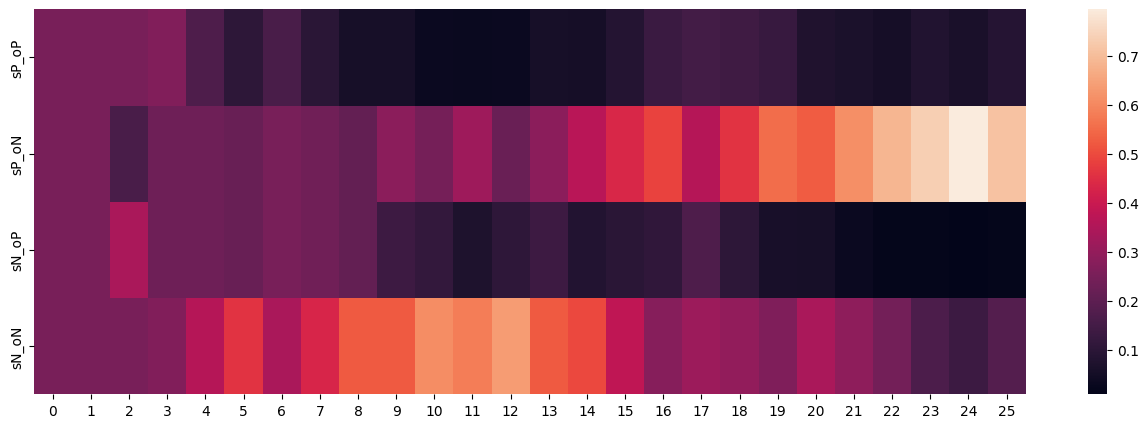

In [14]:
import seaborn as sns

labels = {
    0: "s_pos_o_zer",
    1: "s_neg_o_zer",
    2: "s_zer_o_pos",
    3: "s_zer_o_neg",
    4: "s_zer_o_zer",
}

n_block = 0
n_subject = 0

plt.figure(figsize=(16, 5))
sns.heatmap(samples["beliefs"][0][0][n_block, n_subject].T)
plt.yticks([0.5, 1.5, 2.5, 3.5], labels=agency_names)

exp_condition = samples["states"][-1][0][0]

print(labels[exp_condition[n_block, n_subject].item()])

In [15]:
exp_condition = samples["states"][-1][0][0]
last_beliefs_about_condition = samples["beliefs"][0][..., -1, :]

self_rating = (
    last_beliefs_about_condition[0, ..., 0]
    + last_beliefs_about_condition[0, ..., 1]
    - last_beliefs_about_condition[0, ..., 2]
    - last_beliefs_about_condition[0, ..., 3]
)
other_rating = (
    last_beliefs_about_condition[0, ..., 0]
    + last_beliefs_about_condition[0, ..., 2]
    - last_beliefs_about_condition[0, ..., 1]
    - last_beliefs_about_condition[0, ..., 3]
)

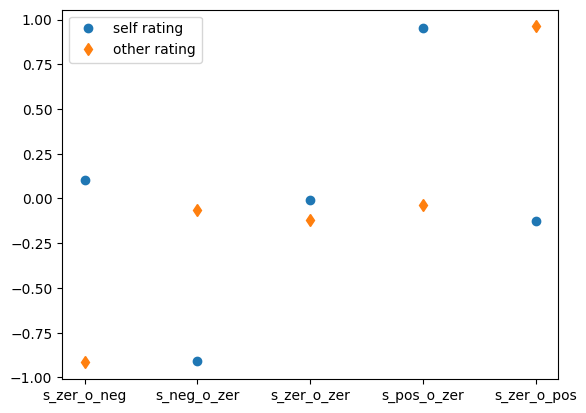

In [16]:
x = []
y1 = []
y2 = []
for i in [3, 1, 4, 0, 2]:
    loc = exp_condition == i
    x.append(labels[i])
    y1.append(self_rating[loc].mean())
    y2.append(other_rating[loc].mean())

plt.plot(x, y1, "o", label="self rating")
plt.plot(x, y2, "d", label="other rating")
plt.legend();

### Parameter recovery with simulated behaviour

In [17]:
measurments = {
    "outcomes": [outcomes[0] for outcomes in samples["outcomes"]],
    "multiactions": samples["multiactions"][0],
    "multiaction_cat": samples["multiaction_cat"][0],
}

posterior = NumpyroGuide(NormalPosterior(num_params, num_agents, backend="numpyro"))

# perform inference using stochastic variational inference
opts_svi = default_dict_numpyro_svi | {"iter_steps": 1000, "seed": 101}
print(opts_svi)

svi_samples, svi, results = run_svi(model, posterior, measurments, opts=opts_svi)

{'seed': 101, 'enumerate': False, 'iter_steps': 1000, 'optim': None, 'optim_kwargs': {'learning_rate': 0.001}, 'elbo_kwargs': {'num_particles': 10, 'max_plate_nesting': 1}, 'svi_kwargs': {'progress_bar': True, 'stable_update': True}, 'sample_kwargs': {'num_samples': 100}}


100%|██████████| 1000/1000 [07:56<00:00,  2.10it/s, init loss: 30181.5840, avg. loss [951-1000]: 17416.7705]


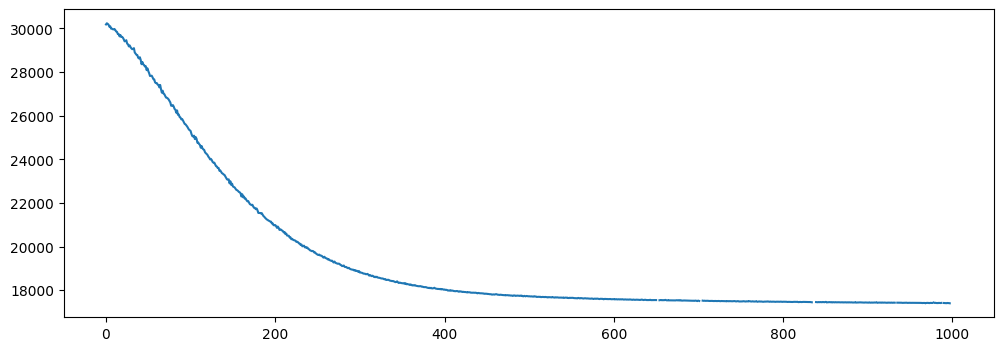

In [18]:
plt.figure(figsize=(12, 4))
plt.plot(results.losses)

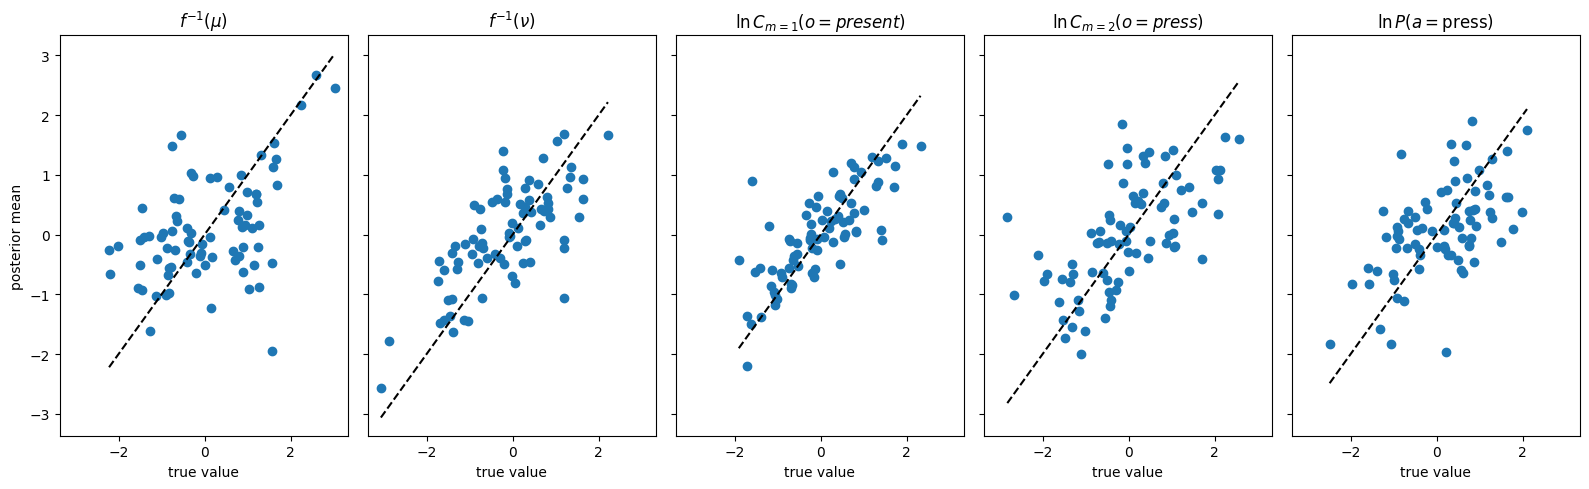

In [19]:
param_label = [
    r"$f^{-1}(\mu)$",
    r"$f^{-1}(\nu)$",
    r"$\ln C_{m=1}(o=present)$",
    r"$\ln C_{m=2}(o=press)$",
    r"$\ln P(a=\text{press})$",
]
z = samples["z"][0]
fig, axes = plt.subplots(1, z.shape[-1], figsize=(16, 5), sharex=True, sharey=True)

for i in range(z.shape[-1]):
    axes[i].scatter(z[:, i], svi_samples["z"].mean(0)[:, i], label=i)
    axes[i].plot((z[:, i].min(), z[:, i].max()), (z[:, i].min(), z[:, i].max()), "k--")
    axes[i].set_xlabel("true value")
    axes[i].set_title(param_label[i])

axes[0].set_ylabel("posterior mean")
fig.tight_layout()